In [13]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

from implementations import *
from utilitaries import *
from additional_functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Data loading
===

In [2]:
from proj1_helpers import *

labels, raw_data, indices = load_csv_data('train.csv', sub_sample=False)
# where b(background) -> -1 and s(signal) -> 1
n_samples, n_raw_features = np.shape(raw_data)
print(f'Dimension: {np.shape(raw_data)}')

Dimension: (250000, 30)


Data preprocessing
===

In [3]:
# A vector contaning the indices of features from raw_data kept for analysis:
feature_indices = []

In [4]:
# Converting meaningless -999 to NaN, computing NaN proportion and remove feature with too many missing 
# values (NaN): unlikely to carry much useful information:

#NaN_prop = 0.3
#reduced_data = remove_meaningless_features(raw_data, NaN_prop)
nan_data = meaningless_to_nan(raw_data)
n_samples, n_nan_features = np.shape(nan_data)
print(f'Dimension: {np.shape(nan_data)}')

Dimension: (250000, 30)


In [22]:
#We can also standardize the data:

std_data = standardize(nan_data)
n_samples, n_features = np.shape(std_data)

[ 52.74979213  35.34481492  40.82860887  63.65555431   0.9384893
 214.22966692   1.93079704   0.78290955  22.2734492  115.70588372
   0.84474126   1.19358245   0.21475866  22.41203584   1.21407622
   1.81675941  22.06487828   1.26497962   1.81660763  32.8946274
   1.81221908 126.49925272   0.97742435  47.00226517   1.38269956
   1.40504495  17.22985913   1.09444375   0.97874075  98.01546598]


Features exploration and selection
===

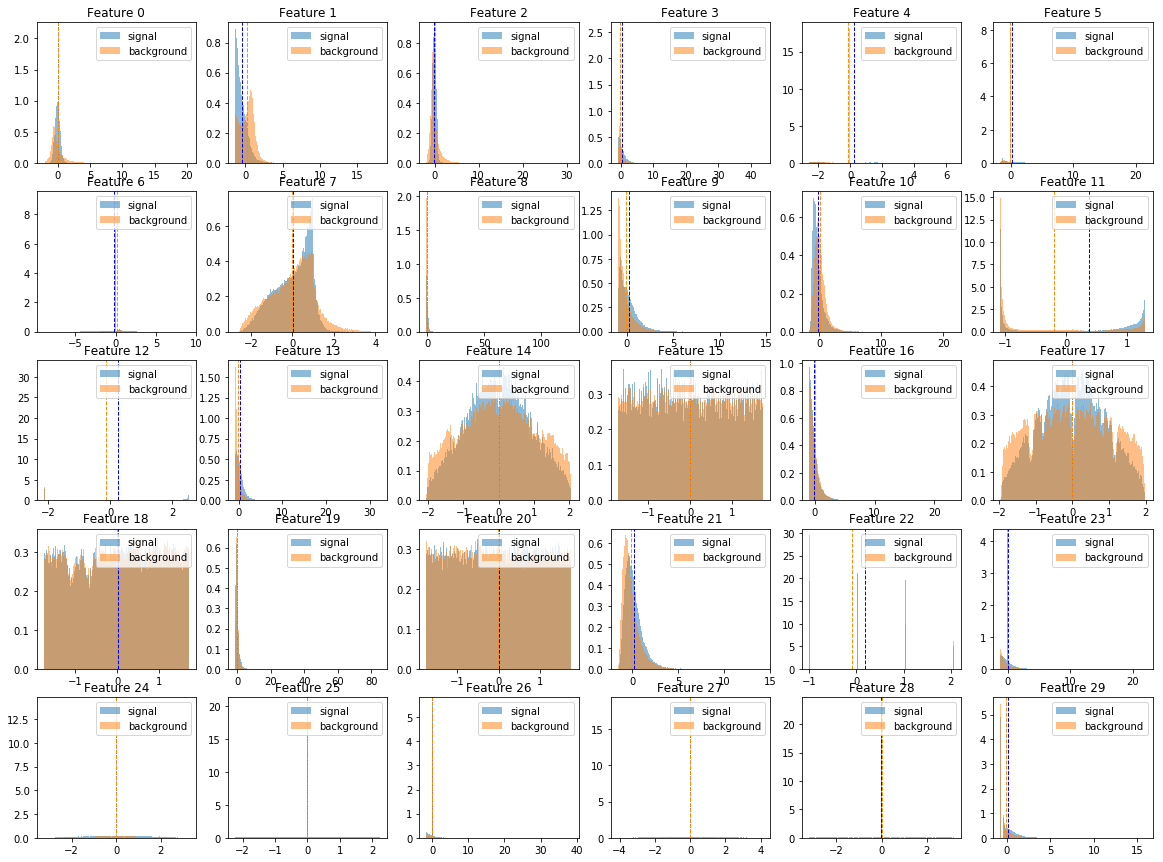

In [6]:
#Let's look at the distribution of each remaining feature:
s_data = std_data[labels == 1,:]
bg_data = std_data[labels == -1,:]

plt.figure(figsize=(20,15))
peaks = 200

for i in range(n_features):
    plt.subplot(5,6,i+1)
    plt.hist(s_data[:,i][~np.isnan(s_data[:,i])], peaks, density=1, alpha=0.5, label='signal')
    plt.hist(bg_data[:,i][~np.isnan(bg_data[:,i])], peaks, density=1, alpha=0.5, label='background')
    plt.axvline(s_data[:,i][~np.isnan(s_data[:,i])].mean(), color='b', linestyle='dashed', linewidth=1)
    plt.axvline(bg_data[:,i][~np.isnan(bg_data[:,i])].mean(), color='darkorange', linestyle='dashed', linewidth=1)
    plt.legend(loc='upper right')
    plt.title(f'Feature {i}') 

Feature reduction
===

In [7]:
# Mean discrimination, we tried this before standardize the data but now it doesn't make sense anymore...

threshold_mean = 0.05 #if background mean < 5%
for i in range(n_features):
    #mean comparison between classes normalized wrt/ feature mean
    diff_mean = (np.abs(np.abs((s_data[:,i]).mean()) - np.abs((bg_data[:,i]).mean()))) / np.abs((std_data[:,i]).mean()) 
    if diff_mean < threshold_mean:
        print('Mean difference:', i, s_data[:,i].mean(), bg_data[:,i].mean(), diff_mean)

In [8]:
# Low variance filter : data columns with too little changes carry little information, we tried this before standardize 
# the data but now it doesn't make sense anymore...

threshold_var = 0.05
variances = np.var(std_data, axis = 0)
for i in range(n_features):
        if variances[i] < threshold_var:
            print('Low variance:', i, variances[i])
        

In [9]:
# High correlation filter : data columns with similar trends carry similar information
# we tried this before standardize the data but now it doesn't make sense anymore...

correlation_pairs = np.ones((2,2))
for i in range(n_features):
    for j in range(n_features):
        correlation_pairs = np.corrcoef(std_data[:,i],std_data[:,j])
        if correlation_pairs[0,1] > 0.85 and i != j:
            print("Feature = {f1} and Feature = {f2}".format(f1=i,f2=j), np.corrcoef(std_data[:,i], std_data[:,j]))

Feature = 9 and Feature = 21 [[1.         0.90448146]
 [0.90448146 1.        ]]
Feature = 9 and Feature = 29 [[1.         0.96562839]
 [0.96562839 1.        ]]
Feature = 21 and Feature = 9 [[1.         0.90448146]
 [0.90448146 1.        ]]
Feature = 21 and Feature = 29 [[1.         0.88441286]
 [0.88441286 1.        ]]
Feature = 29 and Feature = 9 [[1.         0.96562839]
 [0.96562839 1.        ]]
Feature = 29 and Feature = 21 [[1.         0.88441286]
 [0.88441286 1.        ]]


Kept features: 12
Shape of PCA_data: (250000, 12)


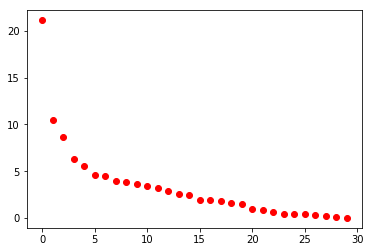

In [10]:
#Principal component analysis - would replace high correlation filter

variance_threshold = 0.80 # need to be tested
eig_val, eig_vec, var = PCA(std_data, variance_threshold)
PCA_data = std_data.dot(eig_vec) #i.e. decorrelated data
print('Shape of PCA_data:', np.shape(PCA_data))
plt.plot([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29], var, 'ro')

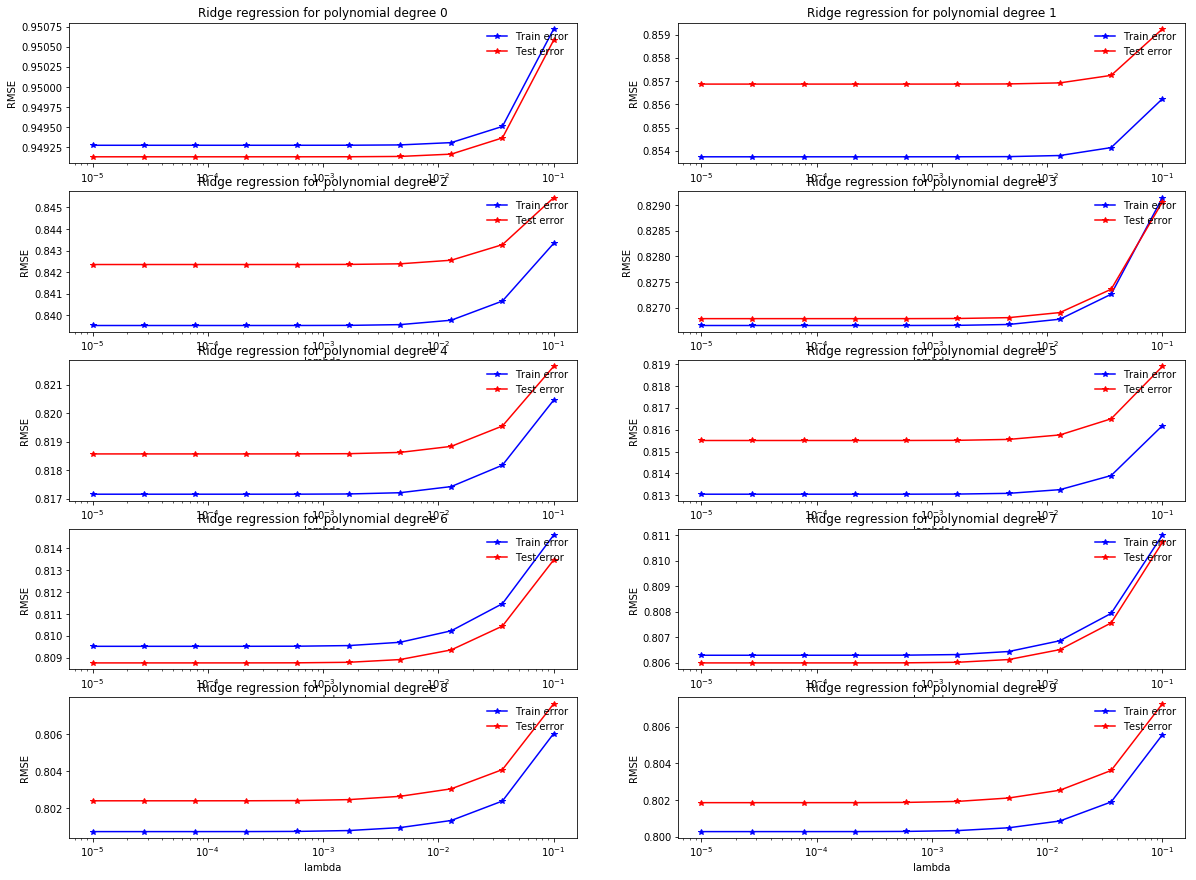

In [15]:
#Ridge regression trial
seed = 56
split_ratio = 0.5
plt.figure(figsize = (20,15))

for degree in range(10):
    plt.subplot(5, 2, degree+1)
    ridge_regression_demo(PCA_data, labels, degree, split_ratio, seed)

In [ ]:
# Ridge regression outcome: polynomial of degree 9

Submission trials
===

In [26]:
#Submission with ridge_regression
#Parameters

chosen_lambda = 0.001
chosen_degree = 8

#Build the model (weights)
reduced_data_poly = build_poly(PCA_data, chosen_degree)
weights, loss = ridge_regression(labels, reduced_data_poly, chosen_lambda)
#print('Weights:',weights)

#Load the test set
labels_te, tx_te, indices_te = load_csv_data('test.csv', sub_sample=False)

#Preprocessing
clean_tx_te = meaningless_to_nan(tx_te)
std_tx_te = standardize(clean_tx_te)

#PCA - dimension reduction
eig_val_te, eig_vec_te, var_te = PCA(std_tx_te, variance_threshold)
PCA_data_te = std_tx_te.dot(eig_vec_te)
reduced_data_poly_te = build_poly(PCA_data_te, chosen_degree)



[5.22855921e+01 3.53934339e+01 4.04739995e+01 6.33043944e+01
 9.40322845e-01 2.15007435e+02 1.93359573e+00 7.79977749e-01
 2.17604313e+01 1.16258143e+02 8.45269936e-01 1.19452041e+00
 2.14705744e-01 2.24364621e+01 1.21326150e+00 1.81577961e+00
 2.21762953e+01 1.26392824e+00 1.81442676e+00 3.23191603e+01
 1.81291407e+00 1.26955949e+02 9.79393394e-01 4.69633307e+01
 1.37625008e+00 1.40650654e+00 1.76222824e+01 1.09625358e+00
 9.79674870e-01 9.84704350e+01]
Kept features: 12


In [27]:
# Make prediction
y_pred = predict_labels(weights, reduced_data_poly_te)
create_csv_submission(indices_te, y_pred, 'submission_PCA_1.csv')